In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # Add this line

import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Set random seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
# load the dataset, split into input (X) and output (y) variables
dataset = np.loadtxt('data/train.csv', delimiter=',', skiprows=1)
X = dataset[:,1:]
print(X)
y = dataset[:, 0]
print(y)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[1. 0. 1. ... 7. 6. 9.]


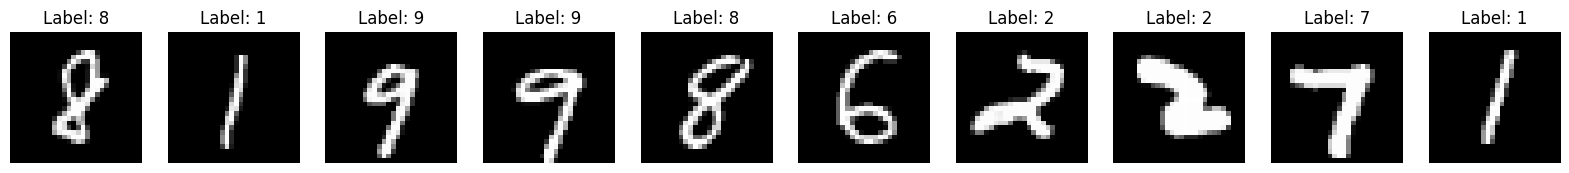

In [5]:
num_samples = 10
sample_indices = np.random.choice(len(X), num_samples, replace=False)
sample_images = X[sample_indices]
sample_labels = y[sample_indices]

# Visualize the samples along with their labels
fig, axes = plt.subplots(1, num_samples, figsize=(20, 2))
for i, ax in enumerate(axes):
    ax.imshow(sample_images[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'Label: {int(sample_labels[i])}')
    ax.axis('off')
plt.show()

In [6]:
# Normalize the training data
X = X / 255.0  # Normalize pixel values to [0, 1]

In [7]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.int64)  # Class indices should be int64

In [8]:
X = X.view(-1, 1, 28, 28)  # Reshape to (batch_size, channels, height, width)
X.size()

torch.Size([42000, 1, 28, 28])

Define Model

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN()

Define Loss Function and Optimizers

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training Loop

In [11]:
n_epochs = 10
batch_size = 64

for epoch in range(n_epochs):
    model.train()
    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i + batch_size]
        ybatch = y[i:i + batch_size]

        optimizer.zero_grad()
        outputs = model(Xbatch)
        loss = loss_fn(outputs, ybatch)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_outputs = model(X)
        _, predictions = torch.max(test_outputs, 1)
        accuracy = (predictions == y).float().mean()
    
    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}')

Epoch 1/10, Loss: 0.0537, Accuracy: 0.9774
Epoch 2/10, Loss: 0.0022, Accuracy: 0.9842
Epoch 3/10, Loss: 0.0193, Accuracy: 0.9879
Epoch 4/10, Loss: 0.0475, Accuracy: 0.9892
Epoch 5/10, Loss: 0.0164, Accuracy: 0.9929
Epoch 6/10, Loss: 0.0316, Accuracy: 0.9931
Epoch 7/10, Loss: 0.0003, Accuracy: 0.9938
Epoch 8/10, Loss: 0.0035, Accuracy: 0.9958
Epoch 9/10, Loss: 0.0007, Accuracy: 0.9962
Epoch 10/10, Loss: 0.0015, Accuracy: 0.9966


Make Predictions

In [12]:
# Load the test dataset
test_data_path = 'data/test.csv'
test_df = pd.read_csv(test_data_path)

# Prepare the test data
test_X = test_df.values
test_X = test_X / 255.0  # Normalize pixel values to [0, 1]
test_X = torch.tensor(test_X, dtype=torch.float32)

test_X = test_X.view(-1, 1, 28, 28)  # Reshape test data
test_X.size()

model.eval()
with torch.no_grad():
    outputs = model(test_X)
    test_predictions = torch.argmax(outputs, dim=1).numpy()

# Create a DataFrame with ImageId and Label
image_ids = np.arange(1, len(test_predictions) + 1)  # Assuming ImageId starts from 1
submission_df = pd.DataFrame({
    'ImageId': image_ids,
    'Label': test_predictions
})

# Save to CSV file
submission_df.to_csv('submission.csv', index=False)

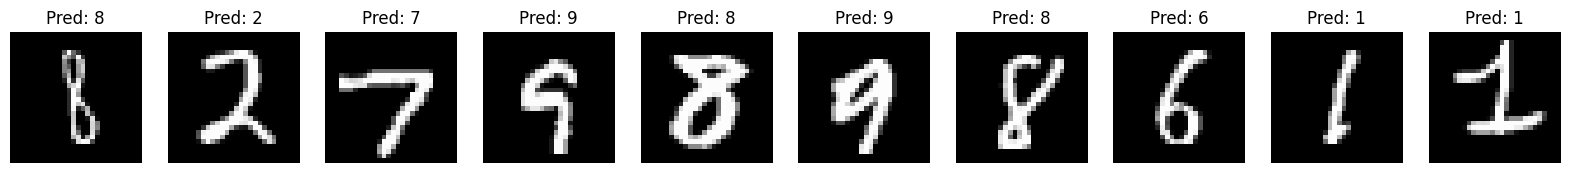

In [13]:
# Select a few samples to visualize
num_samples = 10
sample_indices = np.random.choice(len(test_X), num_samples, replace=False)
sample_images = test_X[sample_indices].numpy()
sample_predictions = test_predictions[sample_indices]

# Visualize the samples along with their predicted labels
fig, axes = plt.subplots(1, num_samples, figsize=(20, 2))
for i, ax in enumerate(axes):
    ax.imshow(sample_images[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'Pred: {sample_predictions[i]}')
    ax.axis('off')
plt.show()